In [1]:
import string

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType

# Spark

In [2]:
spark = SparkSession.builder.getOrCreate()

23/07/19 13:32:50 WARN Utils: Your hostname, Ordenador-portatil-de-Javier.local resolves to a loopback address: 127.0.0.1; using 192.168.0.28 instead (on interface en0)
23/07/19 13:32:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/19 13:33:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Data import

In [3]:
# hdfs_path = 'hdfs://ruta/archivo.csv'

df1 = spark.read.csv("../../kaggle/hate.csv", header=True, inferSchema=True)
df2 = spark.read.csv("../../kaggle/hate2.csv", header=True, inferSchema=True, sep=";")
df3 = spark.read.csv("../../kaggle/hate3.csv", header=True, inferSchema=True)

In [4]:
df1.show()
df2.show()
df3.show()

23/07/19 13:33:33 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , count, hate_speech, offensive_language, neither, class, tweet
 Schema: _c0, count, hate_speech, offensive_language, neither, class, tweet
Expected: _c0 but found: 
CSV file: file:///Users/javier/Dev/Samsung/kaggle/hate.csv


+---+-----+-----------+------------------+-------+-----+--------------------+
|_c0|count|hate_speech|offensive_language|neither|class|               tweet|
+---+-----+-----------+------------------+-------+-----+--------------------+
|  0|    3|          0|                 0|      3|    2|!!! RT @mayasolov...|
|  1|    3|          0|                 3|      0|    1|!!!!! RT @mleew17...|
|  2|    3|          0|                 3|      0|    1|!!!!!!! RT @UrKin...|
|  3|    3|          0|                 2|      1|    1|!!!!!!!!! RT @C_G...|
|  4|    6|          0|                 6|      0|    1|!!!!!!!!!!!!! RT ...|
|  5|    3|          1|                 2|      0|    1|"!!!!!!!!!!!!!!!!...|
|  6|    3|          0|                 3|      0|    1|"!!!!!!""@__Brigh...|
|  7|    3|          0|                 3|      0|    1|!!!!&#8220;@selfi...|
|  8|    3|          0|                 3|      0|    1|""" &amp; you mig...|
|  9|    3|          1|                 2|      0|    1|""" @rhy

23/07/19 13:33:34 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+------------+--------+---------+-------+------+---------+------+----------+--------+--------+-------------+----------+-----------------+--------------------+--------------------+--------------------+------------------+-------+-----------------+------------------+--------------------+-----------------+-------------------+------------------+--------------------------+---------------------------+----------------------------+-----------------+-----------------+-----------+-----------------------+------------------------+-------------------------+---------------------+----------------------+----------------------+----------------------+---------------------+---------------+-----------------------+----------------------------+------------------------------+--------------------------+-------------------+-------------+-----------------+------------------------+-----------------------------+-------------------------------------+-------------------------------+-------------------+---

# Data process

## Dataframe 1

In [5]:
def preprocess_hate1(df_hate1):
    # Rename the columns
    df_hate1 = df_hate1.withColumnRenamed('tweet', 'text').withColumnRenamed('class', 'target')
    # Create the 'target' column
    df_hate1 = df_hate1.withColumn('target', when(col('hate_speech') >= 1, 1).otherwise(0))
    # Drop unnecessary columns
    df_hate1 = df_hate1.drop('Unnamed: 0', 'offensive_language', 'hate_speech', 'count', 'neither')
    # Reorder the columns
    df_hate1 = df_hate1.select('text', 'target')
    
    return df_hate1

In [6]:
df1 = preprocess_hate1(df1)
df1.show(5)

+--------------------+------+
|                text|target|
+--------------------+------+
|!!! RT @mayasolov...|     0|
|!!!!! RT @mleew17...|     0|
|!!!!!!! RT @UrKin...|     0|
|!!!!!!!!! RT @C_G...|     0|
|!!!!!!!!!!!!! RT ...|     0|
+--------------------+------+
only showing top 5 rows



## Dataframe 2

In [7]:
def preprocess_hate2(df_hate2):
    # Rename the columns
    df_hate2 = df_hate2.withColumnRenamed('comment', 'text').withColumnRenamed('isHate', 'target')
    # Convert 'target' column to integer
    df_hate2 = df_hate2.withColumn('target', df_hate2['target'].cast(IntegerType()))
    # Reorder the columns
    df_hate2 = df_hate2.select('text', 'target')
    
    return df_hate2

In [8]:
df2 = preprocess_hate2(df2)
df2.show(5)

+--------------------+------+
|                text|target|
+--------------------+------+
|You should know w...|     1|
|You look like Slo...|     1|
|You look like Rus...|     1|
|Women deserve to ...|     1|
|Women are made fo...|     1|
+--------------------+------+
only showing top 5 rows



## Dataframe 3

In [9]:
def preprocess_hate3(df_hate3):
    # Select the desired columns
    df_hate3 = df_hate3.select('hatespeech', 'text')
    # Rename the columns
    df_hate3 = df_hate3.withColumnRenamed('hatespeech', 'target')
    # Convert 'target' column to integer
    df_hate3 = df_hate3.withColumn('target', df_hate3['target'].cast(IntegerType()))
    # Format the 'target' column
    df_hate3 = df_hate3.withColumn('target', when(col('target') >= 1, 1).otherwise(0))
    # Reorder the columns
    df_hate3 = df_hate3.select('text', 'target')
    
    return df_hate3

In [10]:
df3 = preprocess_hate3(df3)
df3.show(5)

+--------------------+------+
|                text|target|
+--------------------+------+
|"Yes indeed. She ...|     0|
|The trans women r...|     0|
|Question: These 4...|     1|
|It is about time ...|     0|
|For starters bend...|     1|
+--------------------+------+
only showing top 5 rows



# Data Join

In [11]:
data = df1.union(df2).union(df3)

print("Count")
print(f"Df 1 : {df1.count()}")
print(f"Df 2 : {df2.count()}")
print(f"Df 3 : {df3.count()}")
print(f"Data : {data.count()}")

data.show()

Count
Df 1 : 26397
Df 2 : 998
Df 3 : 135556
Data : 162951
+--------------------+------+
|                text|target|
+--------------------+------+
|!!! RT @mayasolov...|     0|
|!!!!! RT @mleew17...|     0|
|!!!!!!! RT @UrKin...|     0|
|!!!!!!!!! RT @C_G...|     0|
|!!!!!!!!!!!!! RT ...|     0|
|"!!!!!!!!!!!!!!!!...|     1|
|"!!!!!!""@__Brigh...|     0|
|!!!!&#8220;@selfi...|     0|
|""" &amp; you mig...|     0|
|""" @rhythmixx_ :...|     1|
|""" Keeks is a bi...|     0|
|""" Murda Gang bi...|     0|
|""" So hoes that ...|     0|
|""" bad bitches i...|     0|
|""" bitch get up ...|     1|
|""" bitch nigga m...|     0|
|""" bitch plz wha...|     0|
|""" bitch who do ...|     1|
|""" bitches get c...|     0|
|""" black bottle ...|     0|
+--------------------+------+
only showing top 20 rows



# Export

In [13]:
data.write.csv('../../kaggle/data')
data.write.json('../../kaggle/data_json')

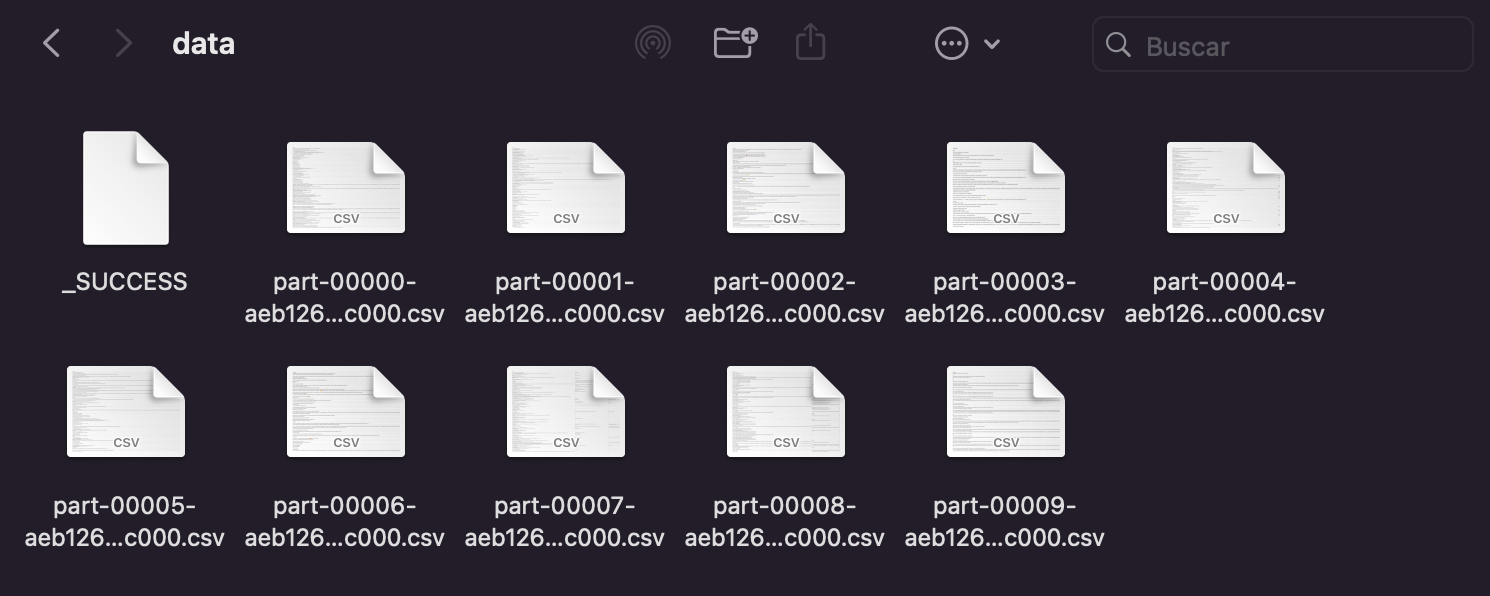

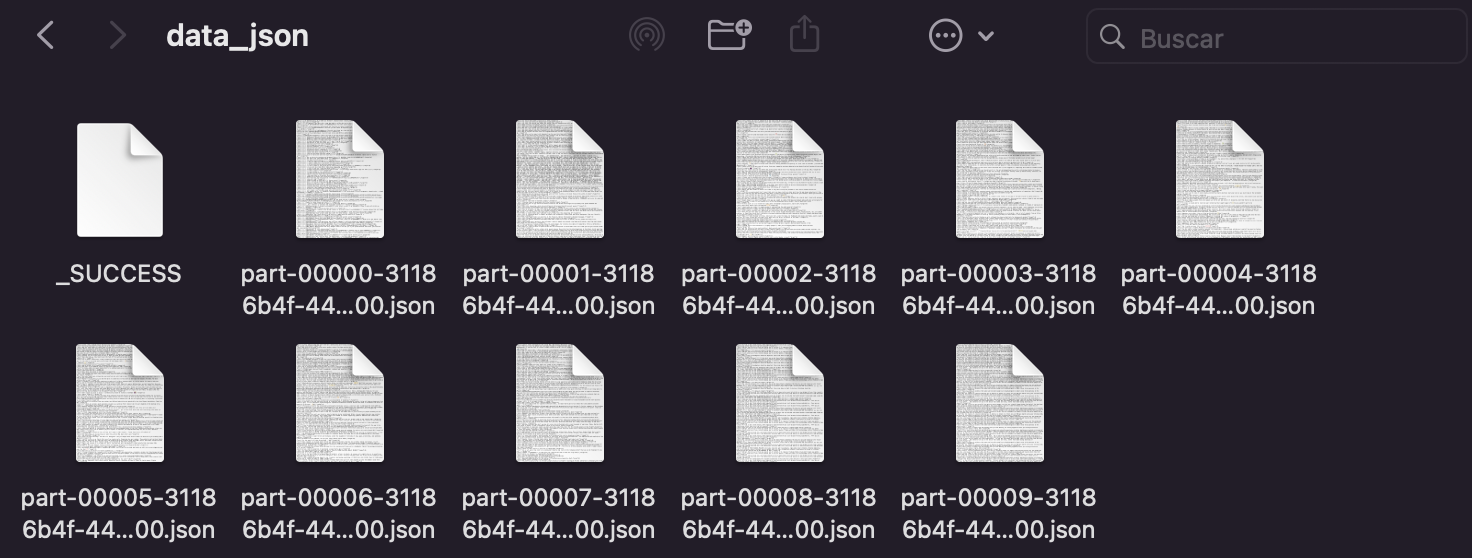